In [1]:
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
# load and split the data
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(
cancer.data, cancer.target, random_state=0)
# compute minimum and maximum on the training data
scaler = MinMaxScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
svm = SVC()
# learn an SVM on the scaled training data
svm.fit(X_train_scaled, y_train)

# scale the test data and score the scaled data
X_test_scaled = scaler.transform(X_test)
print("Test score: {:.2f}".format(svm.score(X_test_scaled, y_test)))


Test score: 0.95


/home/tinhtn/anaconda3/envs/my_env/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [2]:
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma':[0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=5)
grid.fit(X_train_scaled, y_train)
print("Best cross validation accuracy: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)
print("Test set accuracy: {:.2f}".format(grid.score(X_test_scaled, y_test)))

Best cross validation accuracy: 0.98
Best parameters:  {'C': 1, 'gamma': 1}
Test set accuracy: 0.97


In [3]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([("scale", MinMaxScaler()), ("svm", SVC())])
pipe.fit(X_train, y_train)
print("Test score: {:.2f}".format(pipe.score(X_test, y_test)))

Test score: 0.95


/home/tinhtn/anaconda3/envs/my_env/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [4]:
param_grid = {'svm__C': [0.001, 0.01, 0.1, 1, 10, 100],
              'svm__gamma':[0.001, 0.01, 0.1, 1, 10, 100]}

grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross validation accuracy: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)
print("Test set accuracy: {:.2f}".format(grid.score(X_test, y_test)))

Best cross validation accuracy: 0.98
Best parameters:  {'svm__C': 1, 'svm__gamma': 1}
Test set accuracy: 0.97


In [5]:
# Illustrating Information Leakage
from sklearn.feature_selection import SelectPercentile, f_regression
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
import numpy as np

rnd = np.random.RandomState(seed=0)
X = rnd.normal(size=(100, 10000))
y = rnd.normal(size=(100,))
print("Shape of X: {}".format(X.shape))
print("Shape of y: {}".format(y.shape))

select = SelectPercentile(score_func=f_regression, percentile=5).fit(X, y)
X_selected = select.transform(X)
print("Shape of X_selected: {}".format(X_selected.shape))
print("Cross-validation accuracy: {:.2f}".format(np.mean(cross_val_score(Ridge(), X_selected, y, cv=5))))
pipe = Pipeline([("select", SelectPercentile(score_func=f_regression, percentile=5)),
                 ("ridge", Ridge())])
print("Cross-validation accuracy (pipeline): {:.2f}".format(np.mean(cross_val_score(pipe,
                                                                                    X, y, cv=5))))

Shape of X: (100, 10000)
Shape of y: (100,)
Shape of X_selected: (100, 500)
Cross-validation accuracy: 0.91
Cross-validation accuracy (pipeline): -0.25


In [6]:
# Make pipeline
from sklearn.pipeline import make_pipeline
pipe_long = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC(C=100))])
pipe_short = make_pipeline(MinMaxScaler(), SVC(C=100))
print("Pipeline long step: \n{}".format(pipe_long.steps))
print("Pipeline short step: \n{}".format(pipe_short.steps))

Pipeline long step: 
[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('svm', SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))]
Pipeline short step: 
[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('svc', SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))]


In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
pipe = make_pipeline(StandardScaler(), PCA(n_components=2), StandardScaler())
print("Pipeline step: \n{}".format(pipe.steps))
# Access Step Attribute
pipe.fit(cancer.data)
components = pipe.named_steps["pca"].components_
print("Component.shape :{}".format(components.shape))

Pipeline step: 
[('standardscaler-1', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('standardscaler-2', StandardScaler(copy=True, with_mean=True, with_std=True))]
Component.shape :(2, 30)


In [8]:
from sklearn.linear_model import LogisticRegression
pipe = make_pipeline(StandardScaler(), LogisticRegression(solver='lbfgs'))
param_grid = {'logisticregression__C': [0.01, 0.1, 1, 10, 100]}
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=4)
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best estimator:\n{}".format(grid.best_estimator_))
print("\n\nLogistic regression step:\n{}".format(grid.best_estimator_.named_steps["logisticregression"]))
print("\n\nLogistic regression coefficients:\n{}".format(grid.best_estimator_.named_steps["logisticregression"].coef_))

Best estimator:
Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregression', LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False))])


Logistic regression step:
LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)


Logistic regression coefficients:
[[-0.3914328  -0.38953715 -0.37739194 -0.38182177 -0.12563881  0.01490745
  -0.33765699 -0.3786831  -0.05131844  0.22879421 -0.47627084  0.00635852
  -0.35037191 -0.35459504 -0.0298673   0.19405433 -0.0047329  -0.07769192
   0.23537054  0.23109142 -0.5

/home/tinhtn/anaconda3/envs/my_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/tinhtn/anaconda3/envs/my_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/tinhtn/anaconda3/envs/my_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/tinhtn/anaconda3/envs/my_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/tinhtn/anaconda3/envs/my_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: Convergence

Best parameters: {'polynomialfeatures__degree': 2, 'ridge__alpha': 10}
Test-set score: 0.77


/home/tinhtn/anaconda3/envs/my_env/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


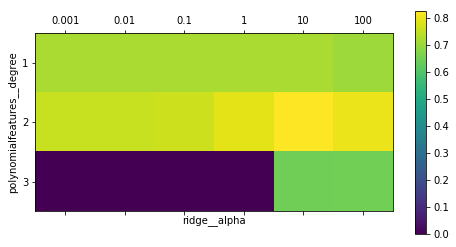

In [19]:
# Grid-Search Preprocessing Step and Model Parameters
from sklearn.datasets import load_boston
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt 

boston = load_boston()
X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target, random_state=0)
pipe = make_pipeline(StandardScaler(), PolynomialFeatures(), Ridge())
param_grid = {'polynomialfeatures__degree':[1, 2, 3],
              'ridge__alpha':[0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

# Visualize
plt.matshow(grid.cv_results_['mean_test_score'].reshape(3, -1), vmin=0, cmap="viridis")
plt.xlabel("ridge__alpha")
plt.ylabel("polynomialfeatures__degree")
plt.xticks(range(len(param_grid['ridge__alpha'])), param_grid['ridge__alpha'])
plt.yticks(range(len(param_grid['polynomialfeatures__degree'])), param_grid['polynomialfeatures__degree'])
plt.colorbar()
print("Best parameters: {}".format(grid.best_params_))
print("Test-set score: {:.2f}".format(grid.score(X_test, y_test)))

In [20]:
# Without polynomial
pipe = make_pipeline(StandardScaler(), Ridge())
param_grid = {'ridge__alpha':[0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

print("Best parameters: {}".format(grid.best_params_))
print("Test-set score: {:.2f}".format(grid.score(X_test, y_test)))

Best parameters: {'ridge__alpha': 10}
Test-set score: 0.63


/home/tinhtn/anaconda3/envs/my_env/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [24]:
# Grid-Search which model to use
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC())])
param_grid = [{'classifier': [SVC()], 'preprocessing': [StandardScaler(), None],
               'classifier__gamma': [0.001, 0.01, 0.1, 1, 10, 100],
               'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]},
              {'classifier': [RandomForestClassifier(n_estimators=100)],
               'preprocessing': [None], 'classifier__max_features':[1, 2, 3]}]
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

print("Best parameter: \n{}\n".format(grid.best_params_))
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Test-set score: {:.2f}".format(grid.score(X_test, y_test)))

Best parameter: 
{'classifier': SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False), 'classifier__C': 10, 'classifier__gamma': 0.01, 'preprocessing': StandardScaler(copy=True, with_mean=True, with_std=True)}

Best cross-validation score: 0.99
Test-set score: 0.98
